<a href="https://colab.research.google.com/github/patrickpato/Machine-learning-from-scratch/blob/main/SentimentAnalysisBoiler_KNN%2BGNB%2BCART__Plate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
import nltk
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import re
nltk.download('words')
nltk.download('stopwords')
from gensim.models import KeyedVectors
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#deep learning algos
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D,MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def load_data(path):
    df = pd.read_csv(path)
    return df
airtel_df = load_data('/content/gdrive/MyDrive/BrandComparison/airtel_labelled.csv')
saf_df = load_data('/content/gdrive/MyDrive/BrandComparison/safaricom_labelled.csv')

In [ ]:
airtel_df.shape, saf_df.shape

((2398, 7), (5258, 7))

In [ ]:
saf_df[['date', 'tweet']].head()

,date,tweet
0,2022-06-03 23:45:24+00:00,"@domoo_d Hi, apologies for the inconvenience c..."
1,2022-06-03 23:34:18+00:00,"@OlingaAbdul : Hello, We're currently experien..."
2,2022-06-03 23:24:11+00:00,@Safaricom_Care I had bought thrice bundles o...
3,2022-06-03 22:53:24+00:00,@Safaricom_Care Please check DM. Thanks
4,2022-06-03 22:51:41+00:00,@Safaricom_Care Hi kindly advise on procedure ...


In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
def clean_tweets(tweets):
    '''
    A function that cleans tweets from their messy raw form to cleaner texts that can be encoded for subsequent preprocessing
    '''
    #removing extra spaces
    regex_pat = re.compile(r'\s+')
    tweets = tweets.str.replace(regex_pat, ' ')
    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweets = tweets.str.replace(regex_pat, '')
    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' 'rt')
    tweets = tweets.str.replace(giant_url_regex, '')
    #removing stopwords
    tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    #removal of punctuations and numbers
    tweets = tweets.str.replace("[^a-zA-Z]", " ")
    # removal of capitalization
    tweets = tweets.str.lower()
    return tweets
saf_df["clean_tweets"] = clean_tweets(saf_df['tweet'])
saf_df.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.


,date,tweet,clean_tweets,positivity_scores,negativity_scores,overall_scores,labels
0,2022-06-03 23:45:24+00:00,"@domoo_d Hi, apologies for the inconvenience c...",hi apologies inconvenience caused kindly fol...,0.265,0.147,0.2500,positive
1,2022-06-03 23:34:18+00:00,"@OlingaAbdul : Hello, We're currently experien...",hello we re currently experiencing system i...,0.300,0.000,0.8271,positive


In [ ]:
#saf_df['clean_tweets'] = clean_tweets(saf_df['tweet'])
airtel_df['clean_tweets'] = clean_tweets(airtel_df['tweet'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
airtel_df.head(2)

,date,tweet,clean_tweets,positivity_scores,negativity_scores,overall_scores,labels
0,2022-06-03 21:55:27+00:00,@UgandaCranes @Airtel_Ug @NileSpecial @Officia...,go cranes lord thee,0.0,0.0,0.0,neutral
1,2022-06-03 21:40:13+00:00,@UgandaCranes @Airtel_Ug @NileSpecial @Officia...,goalless draw written fixture,0.0,0.0,0.0,neutral


# EDA

In [ ]:
def get_sentiment_distribution(df, brand):
    df['labels'].value_counts().plot(kind='pie', autopct='%.1f%%')
    plt.title("Distribution of sentiments for {}" .format(brand))

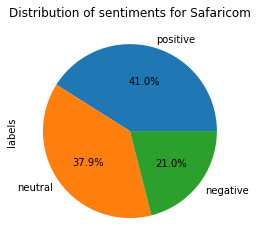

In [ ]:
get_sentiment_distribution(saf_df, "Safaricom")

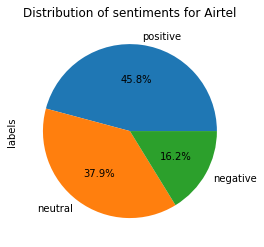

In [ ]:
get_sentiment_distribution(airtel_df, "Airtel")

In [ ]:
def get_average_chars_per_tweet(tweets, brand):
    tweet_word_count = tweets.str.split().map(lambda x: len(x))
    sns.distplot(tweet_word_count.map(lambda x: np.mean(x)),hist=False,  color="purple")
    plt.title("Character length distribution in {} tweets" .format(brand))
    plt.xlabel("Number of character")
    plt.ylabel("Density of occurence")
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


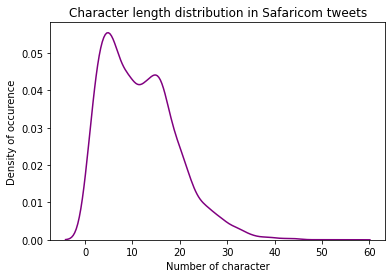

In [ ]:
get_average_chars_per_tweet(saf_df['clean_tweets'], "Safaricom")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


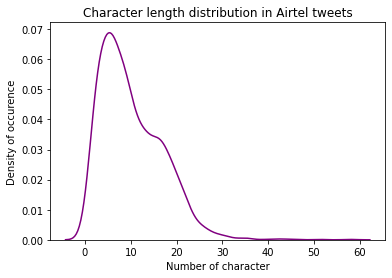

In [ ]:
get_average_chars_per_tweet(airtel_df['clean_tweets'], "Airtel")

# Common words per sentiment
## Safaricom

In [ ]:
def word_cloud_per_sentiment(df, sentiment):
    wc = WordCloud(stopwords=stopwords,
               background_color="black",
               max_words=150, max_font_size=25,
               random_state=42)
    wc.generate(str(df[df.iloc[:, -1]==sentiment]['clean_tweets']))
    #wc.generate(str(df[df==sentiment]['clean_text-stopwords']))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

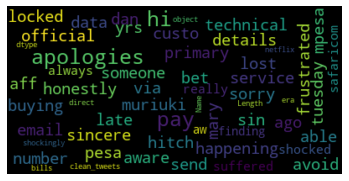

In [ ]:
word_cloud_per_sentiment(saf_df, "negative")

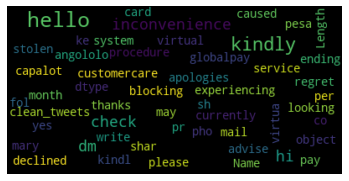

In [ ]:
word_cloud_per_sentiment(saf_df, "positive")

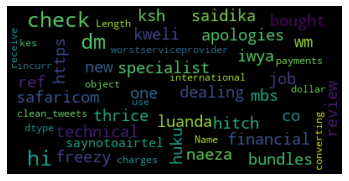

In [ ]:
word_cloud_per_sentiment(saf_df, "neutral")

# Airtel

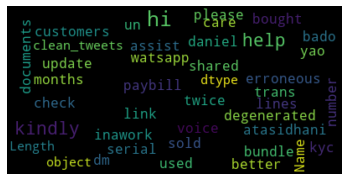

In [ ]:
word_cloud_per_sentiment(airtel_df, "positive")

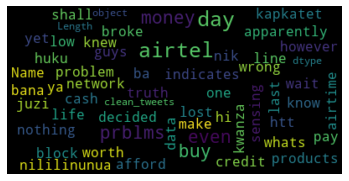

In [ ]:
word_cloud_per_sentiment(airtel_df, "negative")

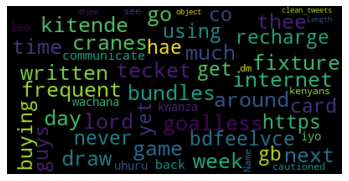

In [ ]:
word_cloud_per_sentiment(airtel_df, "neutral")

# Feature Extraction

In [ ]:
def cv_text_vectorizer(text):
    '''
    A python function that converts input text into vectors to be fed into ML algos. 
    Here we experiment with count vectorizer .  
    '''
    cv = CountVectorizer()
    cv_vectors = cv.fit_transform(text)
    return cv_vectors, cv.get_feature_names_out()
def tfidf_text_vectorizer(text):
    """
    Implementation of TFIDF vectorizer for text encoding
    """
    tfidf_vect = TfidfVectorizer(ngram_range=(2,2))
    vectors = tfidf_vect.fit_transform(text)
    return vectors, tfidf_vect.get_feature_names

In [ ]:
cvVectors_saf, feature_names_saf = cv_text_vectorizer(saf_df['clean_tweets'])
tfidfVectors_saf, tfidf_feat_names_saf = tfidf_text_vectorizer(saf_df['clean_tweets'])

In [ ]:
cvVectors_airtel, feature_names_airtel = cv_text_vectorizer(airtel_df['clean_tweets'])
tfidfVectors_airtel, tfidf_feat_names_airtel = tfidf_text_vectorizer(airtel_df['clean_tweets'])

# Modelling 

In [ ]:
labels_saf = saf_df['labels']
labels_airtel = airtel_df['labels']
def data_preprocessing(features, target):
    enc = LabelEncoder()
    target = enc.fit_transform(target)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)
    return X_train,X_test, y_train, y_test


In [ ]:
cv_train_saf, cv_test_saf, y_train_saf, y_test_saf = data_preprocessing(cvVectors_saf, labels_saf)
tfidf_train_saf, tfidf_test_saf, y_train_saf, y_test_saf = data_preprocessing(tfidfVectors_saf, labels_saf)

In [ ]:
cv_train_airtel, cv_test_airtel, y_train_airtel, y_test_airtel = data_preprocessing(cvVectors_airtel, labels_airtel)
tfidf_train_airtel, tfidf_test_airtel, y_train_airtel, y_test_airtel = data_preprocessing(tfidfVectors_airtel, labels_airtel)

# Count vectorizer results -Safaricom

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('MNB', MultinomialNB()))
models.append(("GNB", GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(("XGB", XGBClassifier()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("MLP", MLPClassifier()))

model_results = list()
model_names = list()
metric = "accuracy"
for model_name, model in models:
    clf = model
    clf.fit(cv_train_saf.toarray(), y_train_saf)
    predictions = clf.predict(cv_test_saf.toarray())
    clf_score = accuracy_score(predictions, y_test_saf)
    model_results.append(clf_score)
    model_names.append(model_name)
    msg = "%s: %f" % (model_name, clf_score.mean())
    print(msg)


LR: 0.812928
MNB: 0.690494
GNB: 0.482129
SVM: 0.739924
RF: 0.802281
XGB: 0.726996
KNN: 0.498859
CART: 0.763498
MLP: 0.802281


# TFIDF Results -Safaricom

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('MNB', MultinomialNB()))
models.append(("GNB", GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(("XGB", XGBClassifier()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("MLP", MLPClassifier()))

model_results = list()
model_names = list()
metric = "accuracy"
for model_name, model in models:
    clf = model
    clf.fit(tfidf_train_saf.toarray(), y_train_saf)
    predictions = clf.predict(tfidf_test_saf.toarray())
    clf_score = accuracy_score(predictions, y_test_saf)#percentages
    model_results.append(clf_score)
    model_names.append(model_name)
    msg = "%s: %f" % (model_name, clf_score.mean())
    print(msg)

LR: 0.610646
MNB: 0.535361
GNB: 0.476046
SVM: 0.533840
RF: 0.568821
XGB: 0.534601
KNN: 0.394677
CART: 0.563498
MLP: 0.616730


# Airtel Results
## CV

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', MultinomialNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(("XGB", XGBClassifier()))

model_results = list()
model_names = list()
metric = "accuracy"
for model_name, model in models:
    clf = model
    clf.fit(cv_train_airtel, y_train_airtel)
    predictions = clf.predict(cv_test_airtel)
    clf_score = accuracy_score(predictions, y_test_airtel)
    model_results.append(clf_score)
    model_names.append(model_name)
    msg = "%s: %f" % (model_name, clf_score.mean())
    print(msg)


LR: 0.813333
NB: 0.721667
SVM: 0.770000
RF: 0.790000
XGB: 0.813333


In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', MultinomialNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(("XGB", XGBClassifier()))

model_results = list()
model_names = list()
metric = "accuracy"
for model_name, model in models:
    clf = model
    clf.fit(tfidf_train_airtel, y_train_airtel)
    predictions = clf.predict(tfidf_test_airtel)
    clf_score = accuracy_score(predictions, y_test_airtel)
    model_results.append(clf_score)
    model_names.append(model_name)
    msg = "%s: %f" % (model_name, clf_score.mean())
    print(msg)

LR: 0.631667
NB: 0.578333
SVM: 0.630000
RF: 0.648333
XGB: 0.605000


In [ ]:
saf_df.to_csv("safaricom_labelled.csv", index=False), airtel_df.to_csv("airtel_labelled.csv", index=False)

(None, None)